# Projet Lignes de niveau

On importe ces modules par principe de precaution

In [5]:
import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

 Ceci est le notebook Jupyter contenant le projet de dessin de lignes de niveau sous python de Maud Roux-Salembien et Jérémy Costanzo

Soit f une fonction de $[0,1]^2$ vers $\mathbb{R}$ supposée continuement différentiable.

On cherche les ensembles de la forme : {$(x,y)\in\mathbb{R}^2|f(x,y)=c$} où c $\in$ $\mathbb{R}$



## <u>Contour simple</u>

### Amorce : 

Soit c $\in$ $\mathbb{R}$

On cherche une condition suffisante sur f(0,0) et f(0,1) pour qu'il existe t $\in$ [0,1] tel que f(0,t) = c

On sait que f est continuement différentiable, donc en particulier f(0,.), qui désigne la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(0,t).
\end{align*}$
est continue.


Ainsi, si c appartient au segment [min(f(0,0),f(0,1)),max(f(0,0),f(0,1))], le théorème des valeurs intermédiaires nous assure l'existence d'un t $\in$ [0,1] solution de f(0,t) = c.

Si la condition évoquée est satisfaite, on peut chercher numériquement une solution en utilisant la méthode de la dichotomie :

In [6]:
def find_seed(g,c=0,eps=2**(-26)):
    if (g(0)-c)*(g(1)-c) > 0:
        return None
    else:
        a = 0
        b = 1
        while b-a > eps:
            m = (a+b)/2
            if (g(m)-c)*(g(a)-c)<=0:
                b = m
            else:
                a = m
        t = (a+b)/2
        return t

La méthode des tangentes de Newton converge plus rapidement, mais nécessite plus d'hypothèses, et on ne peut pas savoir à quel point on est éloigné d'une solution, alors que la méthode de la dichotomie ne nécessite que la continuité de g, et permet de majorer la distance à une solution.

### Propagation

Une première approche pour implémenter la fonction simple_contour consisterait à subdiviser [0,1] en segments de taille $\delta$, et d'utiliser find_seed(g,c,eps) où g est la fonction $\begin{align*}
  [0,1] &\to \mathbb{R}\\
  t &\mapsto f(k\delta,t)
\end{align*}$ où k varie de 0 à int(1/$\delta$). Mais cela n'est pas satisfaisant, il faudrait réaliser environ 1/$\delta$ dichotomies, et l'équation f(k$\delta$,t) = c peut admettre plusieurs solutions éloignées les unes des autres.

Pour la suite, nous avons besoin de calculer le gradient de f en un point. Ainsi nous implementons une classe pt qui permet de representer des elements de $\mathbb{R}^2$, donc des points ou des vecteurs.

In [7]:
tolerance = 1**(-7) #un petit flottant, choisi un peu au pif pour l'instant...

class pt:
    def __init__(self,x=0.0,y=0.0):
        self.x = x
        self.y = y
    
    def __repr__(self):
        return('{'+str(self.x)+','+str(self.y)+'}')
        
    def __mul__(a,b):
        if isinstance(b,int) or isinstance(b,float):
            return pt(a.x*b,a.y*b)
        else:
            return pt(a.x*b.x,a.y*b.y)
            
    def __rmul__(a,b):
        if isinstance(a,int) or isinstance(a,float):
            return pt(a*b.x,a*b.y)
        else:
            return a*b
    def __neg__(self):
        return pt(-self.x,-self.y)
        
    def __add__(a,b):
        return pt(a.x+b.x,a.y+b.y)  
    
    def __inv__(self):
        return pt(1/self.x,1/self.y)
    
    def __div__(self,b):
        return (self * (1/b))
    
    def __rdiv__(self,b):
        return pt(b.x/self,b.y/self)
    
    def norme(self):
        return (self.x**2 + self.y**2)**0.5

    def normalized(self):
        return(self*(1/(self.norme())))
        
    def __sub__(self,b):
        return self+ (-b)
        
    def orth(self):
        return pt(-self.y,self.x)

def list_x_y(p):
    x,y = [],[]
    for i in p:
        x.append(i.x)
        y.append(i.y)
    return(np.array(x),np.array(y))
    
def dist(a,b):
    return (a-b).norme()
    
def grad(f,p=pt()):
    autog = autograd.grad
    t = np.r_[autog(f,0)(p.x,p.y),autog(f,1)(p.x,p.y)]
    return pt(t[0],t[1])

Nous implementons maintenant la fonction ingrid : ingrid(p,grid) renvoie : p $\in$ grid ou grid est en fait un ensemble de la forme [a,b]x[c,d] où (a,b,c,d) $\in \mathbb{R}^4$.

In [8]:
def ingrid(p,grid):
    return(grid[0]<=p.x<=grid[1] and grid[2]<=p.y<=grid[3])    

Les fonctions suivantes permettent de se reperer sur un cercle de rayon delta centre sur un point p0.

In [9]:
def p_a1(ang):
    """
    Cette fonction calcule le point p sur le cercle unite tel que l'angle oriente (pt(1,0),p) vale ang
    """
    return(pt(np.cos(ang),np.sin(ang)))    

def rad(p):
    """
    Cette fonction calcule l'angle oriente (pt(1,0),p)
    """
    pn = p.normalized()
    x = pn.x
    y = pn.y
    if y > 0:
        return np.arccos(x)
    else:
        return -np.arccos(x)
    
def theta(p0,p):
    """
    calcule l'angle oriente (p0+pt(delta,0),p) ou delta = dist(p0,p)
    """
    return rad(p) - rad(p0)

def p_a(p0,th,delta):
    """
    calcule le point p tel que dist(p,p0) = delta et theta(p0,p) = th
    """
    p = delta*p_a1(th)
    return(p0+p)

def newton(f,p0,c,eps=10**-4):
    def fun(x,y):
        return (f(x,y)-c)
    def proch(p): #proch joue le role de l'application contractante pour l'application du theoreme du point fixe
        g = grad(f,p)
        return(p - (fun(p.x,p.y)/(g.norme()**2))*g)
    p1 = proch(p0)
    while dist(p0,p1) > eps:
        p0 = p1
        p1 = proch(p1)
    return(p1)

def g(f,p0,theta,d) :
    return f(p0.x+d*np.cos(theta),p0.y+d*np.sin(theta))

def dichotoproch(f,c,delta,ad,d):
    ref = (d - ad) + d
    ang = theta(d + pt(delta,0),ref)
    def rech(th):
        return g(f,d,th-ang,delta)
    a = -np.pi + delta
    b =  np.pi - delta
    while b-a > delta:
        m = (a+b)/2
        if (rech(m)-c)*(rech(a)-c)<=0:
            b = m
        else:
            a = m
    t = (a+b)/2
    return p_a(d,t+ang,delta)

In [10]:
theta(pt(1,1),pt(0.2,2))

0.6857295109062861

Description de suivant, de la methode des tangentes, contour simple...

In [11]:
def suivant(f,ad,d,c,delta):
    p0 = d + delta*grad(f,d).normalized().orth()
    p1 = d - delta*grad(f,d).normalized().orth()
    s = pt()
    if dist(p0,ad) > dist(p1,ad):
        s = p0
    else:
        s = p1
    pr = newton(f,s,c,delta*tolerance)
    return(pr)

def simple_contour(f,c=0.0, delta =0.01,grid = [0.0,1.0,-1.0,1.0],cote= lambda x: f(0,x),i = 0): #i designe le cote de la grille : il appartient à [|0,3|]
    t = find_seed(cote,c)
    if t == None:
        return [],[]
    p0 = pt()
    if i < 2:
        p0 = pt(grid[i],find_seed(cote,c))
    else:
        p0 = pt(find_seed(cote,c),grid[i])
    g0 = grad(f,p0)
    p11 = p0 + (g0.normalized().orth() * delta)
    p12 = p0 - (g0.normalized().orth() * delta)
    p1t = pt()
    if ingrid(p11,grid):
        p1t = p11
    elif ingrid(p12,grid):
        p1t = p12
    else:
        return [],[]
    p1 = newton(f,p1t,c,tolerance*delta)
    p2 = suivant(f,p0,p1,c,delta)
    pts = [p0,p1,p2]
    pa = p0 #avant-avant dernier point calculé
    pb = p1 #avant-dernier
    pc = p2 #dernier point calculé
    compt = 0
    while dist(pc,p0) > delta and dist(pc,pa) > delta and compt < 100000:
        compt += 1
        pa = pb
        pb = pc
        #pc = suivant(f,pb,pc,c,delta)
        pc = dichotoproch(f,c,delta,pa,pb)
        pts.append(pc)
        if not ingrid(pc,grid):
            return list_x_y(pts)
        #else:
        #    if dist(pc,pa) > delta/2:
        #        pts.append(pc)
        #    else:
        #        pc = dichotoproch(f,c,delta,pa,pb)
        #        pts.append(pc)
    return list_x_y(pts)    

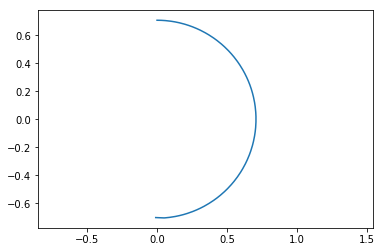

In [12]:
def f(x,y):
    return x**2 + y**2
plt.axis("equal")
si = simple_contour(f,0.5)
plt.plot(si[0],si[1])

## Contour complexe

On veut maintenant quadriller notre espace pour trouver des amorces ailleurs pour les lignes de niveau.
On va appeler contour_simple sur ces grilles.
On définit la fonction bord, qui renvoie une fonction $[0,1] \rightarrow \mathbb{R}$, qui va nous servir à trouver une amorce pour chacun des 4 côtés de la cellule.

In [27]:
def bord(f,p1,p2,n):
                """
                bord(f,p1,p2,n) renvoie une application partielle qui va etre utilisee par find_seed pour trouver une amorce a une ligne de niveau.
                """
                if n == 0:
                    return(lambda x: f(p1.x,p2.y + (p1.y-p2.y)*x))
                elif n == 1:
                    return(lambda x: f(p1.x + (p2.x-p1.x)*x,p1.y))
                elif n == 2:
                    return(lambda t: f(p2.x, p2.y + (p1.y-p2.y)*t))
                elif n == 3:
                    return(lambda t: f(p1.x + (p2.x-p1.x)*t, p2.y))
            
#def contour(f,c=0.0,xc=[0.0,1.0],yc=[0.0,1.0],delta = 0.01):
#    xs,ys = [],[]
#    for i in range(len(xc)-1):
#        for j in range(len(yc)-1):
#            grid = [xc[i],yc[j],xc[i+1],yc[j+1]]
#            p1 = pt(xc[i],yc[i])
#            p2 = pt(xc[i+1],yc[j+1])
#            
#            for n in range(4):    
#                appp = bord(f,p1,p2,n)
#                x,y = simple_contour(f,c,delta,grid,appp,n)
#                xs.append(x)
#                ys.append(y)
#    return(xs,ys)

In [28]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves


In [40]:
grille_x = np.linspace(-5,5,20)
grille_y = np.linspace(-5,5,20)

xs,ys = contour(f,1,grille_x,grille_y,0.01)

for x,y in zip(xs,ys):
    plt.plot(x,y)
plt.show()

ValueError: too many values to unpack (expected 2)